In [1]:
'''in this version we always use the same image (times batch size)'''

'in this version we always use the same batch of images'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


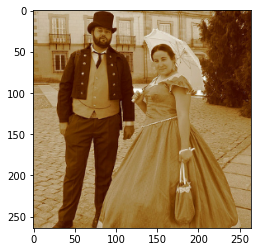

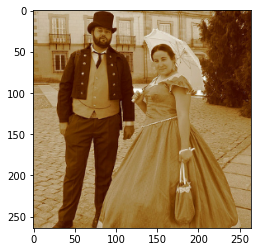

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False
config.fixed_image_num = 1 #this is a nice image
config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                    deterministic=True,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])
if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model)

In [ ]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs = agent.get_action(env.unflatten_observation(prev_state),
                                               return_stats=True)
        action = deterministic_action #hook in order to add noise if neccessary
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(prev_state)
            actions.append(action)
            rewards.append(reward)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.mean(axis=0))
            action_var_records.append(deterministic_action.var(axis=0))
            action_statmean_records.append(means)
            action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards),shaper_fn=env.unflatten_observation_v2,
                max_iterations=1000, loud=True)
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Episode * 0 * Episodic Reward is ==> -11.804356575012207
action means and variances at step -10: [ 0.08824686 -0.1958277 ] [0.54733117 0.83579134]
action means and variances at step -5: [ 0.10903452 -0.10771459] [0.82947665 0.68965476]
action statmeans and variances at step -10: [-0.04161055 -0.00126782] [1. 1.]
action statmeans and variances at step -5: [-0.03995169  0.00778066] [1. 1.]
Episode * 1 * Episodic Reward is ==> -11.840102195739746
action means and variances at step -10: [0.09846652 0.19412215] [1.19360419 0.77061659]
action means and variances at step -5: [0.37673084 0.05035401] [1.38731857 0.91046496]
action statmeans and variances at step -10: [0.0592532  0.00282508] [1. 1.]
action statmeans and variances at step -5: [0.05897958 0.00587308] [1. 1.]
Episode * 2 * Episodic Reward is ==> -11.667491912841797
action means and variances at step -10: [-0.12425606 -0.05897043] [1.08527685 0.96517313]
action means and variances at step -5: [-0.09424318 -0.10866115] [1.04919309 1.

Episode * 13 * Episodic Reward is ==> -12.183853149414062
action means and variances at step -10: [-0.1824775   0.12986957] [0.96230047 0.78990183]
action means and variances at step -5: [-0.13982328 -0.1401282 ] [1.02708718 0.72693754]
action statmeans and variances at step -10: [-0.07647309 -0.12794998] [1. 1.]
action statmeans and variances at step -5: [-0.08124304 -0.13364987] [1. 1.]
Episode * 14 * Episodic Reward is ==> -12.093219757080078
action means and variances at step -10: [-0.28073804 -0.14622001] [0.55873593 0.75725455]
action means and variances at step -5: [-0.34393956 -0.28847846] [1.17423827 0.59899574]
action statmeans and variances at step -10: [-0.08940043 -0.11408269] [1. 1.]
action statmeans and variances at step -5: [-0.08826391 -0.1119609 ] [1. 1.]
Episode * 15 * Episodic Reward is ==> -12.168010711669922
action means and variances at step -10: [-0.23112178 -0.12305489] [1.21023555 0.79600573]
action means and variances at step -5: [-0.01106421  0.10884908] [0.

Episode * 26 * Episodic Reward is ==> -11.844776153564453
action means and variances at step -10: [-0.10216427 -0.04497632] [0.79235607 0.72316935]
action means and variances at step -5: [-0.34725598 -0.27143309] [1.29709773 1.12453627]
action statmeans and variances at step -10: [-0.19593307 -0.07221216] [1. 1.]
action statmeans and variances at step -5: [-0.2000682  -0.07864718] [1. 1.]
Episode * 27 * Episodic Reward is ==> -11.66882038116455
action means and variances at step -10: [-0.37673137  0.40180357] [1.15379562 0.74280704]
action means and variances at step -5: [ 0.00128606 -0.36113078] [1.06822318 0.69475076]
action statmeans and variances at step -10: [-0.1997285  -0.03012573] [1. 1.]
action statmeans and variances at step -5: [-0.20098183 -0.02988812] [1. 1.]
Episode * 28 * Episodic Reward is ==> -11.89614200592041
action means and variances at step -10: [-0.30770091  0.20578485] [0.9426362  0.96438075]
action means and variances at step -5: [-0.29377742 -0.42322215] [1.06

Episode * 39 * Episodic Reward is ==> -11.64952278137207
action means and variances at step -10: [-0.13167295 -0.03643973] [0.97750239 0.95802296]
action means and variances at step -5: [-0.00799921 -0.04878813] [0.68875082 1.38427975]
action statmeans and variances at step -10: [-0.20287779  0.02718994] [1. 1.]
action statmeans and variances at step -5: [-0.19648007  0.02736812] [1. 1.]
Episode * 40 * Episodic Reward is ==> -11.877052307128906
action means and variances at step -10: [-0.36017566  0.11906441] [0.94741476 0.83936638]
action means and variances at step -5: [-0.44919436  0.01284211] [0.97162918 1.00696655]
action statmeans and variances at step -10: [-0.21781176  0.00039731] [1. 1.]
action statmeans and variances at step -5: [-0.20721754  0.00892434] [1. 1.]
Episode * 41 * Episodic Reward is ==> -11.903979301452637
action means and variances at step -10: [-0.22437899 -0.21326154] [0.68607205 1.02444828]
action means and variances at step -5: [-0.19178582  0.26033764] [0.8

Episode * 52 * Episodic Reward is ==> -12.00330924987793
action means and variances at step -10: [ 0.12181024 -0.04099499] [1.38924509 1.29272935]
action means and variances at step -5: [0.094515   0.06690724] [1.02802522 0.55446256]
action statmeans and variances at step -10: [-0.07001085  0.00610564] [1. 1.]
action statmeans and variances at step -5: [-0.07190949  0.00464933] [1. 1.]
Episode * 53 * Episodic Reward is ==> -11.675727844238281
action means and variances at step -10: [-0.08954357  0.00898165] [1.05982214 0.93953603]
action means and variances at step -5: [-0.11311507 -0.18908023] [1.5977037  1.21151816]
action statmeans and variances at step -10: [-0.03986859 -0.00811083] [1. 1.]
action statmeans and variances at step -5: [-0.04109108 -0.00861651] [1. 1.]
Episode * 54 * Episodic Reward is ==> -12.156778335571289
action means and variances at step -10: [-0.11135441  0.29186058] [0.85440222 1.29176983]
action means and variances at step -5: [-0.14097251  0.09855937] [0.922

Episode * 65 * Episodic Reward is ==> -11.93738842010498
action means and variances at step -10: [ 0.14825221 -0.15713842] [1.13137135 0.86611036]
action means and variances at step -5: [-0.20836119  0.06600728] [0.84876326 1.27867569]
action statmeans and variances at step -10: [-0.12078999 -0.08892157] [1. 1.]
action statmeans and variances at step -5: [-0.12291822 -0.08716004] [1. 1.]
Episode * 66 * Episodic Reward is ==> -12.098978996276855
action means and variances at step -10: [-0.21170968  0.10399626] [0.99894294 1.12012586]
action means and variances at step -5: [-0.24025155 -0.07483474] [1.16358016 0.7902789 ]
action statmeans and variances at step -10: [-0.1744734  -0.15315787] [1. 1.]
action statmeans and variances at step -5: [-0.18842587 -0.16432655] [1. 1.]
Episode * 67 * Episodic Reward is ==> -11.799098014831543
action means and variances at step -10: [ 0.037559   -0.08779885] [0.94625924 0.56110721]
action means and variances at step -5: [-0.3847988  -0.03115021] [1.4

Episode * 78 * Episodic Reward is ==> -11.897186279296875
action means and variances at step -10: [-0.42330572 -0.07205581] [0.64063077 0.78623111]
action means and variances at step -5: [0.08503561 0.06199735] [0.92141044 0.94416248]
action statmeans and variances at step -10: [-0.20160633 -0.06321228] [1. 1.]
action statmeans and variances at step -5: [-0.1950848  -0.06124412] [1. 1.]
Episode * 79 * Episodic Reward is ==> -11.925029754638672
action means and variances at step -10: [ 0.04169121 -0.42708099] [1.63537698 0.93895766]
action means and variances at step -5: [-0.35327538 -0.04271458] [0.9867546  0.91578454]
action statmeans and variances at step -10: [-0.21582064 -0.04702827] [1. 1.]
action statmeans and variances at step -5: [-0.27184153 -0.08107598] [1. 1.]
Episode * 80 * Episodic Reward is ==> -12.000577926635742
action means and variances at step -10: [0.05580303 0.14607024] [0.80319632 1.1433376 ]
action means and variances at step -5: [ 0.14283579 -0.34526589] [1.1914

Episode * 91 * Episodic Reward is ==> -11.68033218383789
action means and variances at step -10: [-0.43132415  0.1662432 ] [0.976438   0.86583336]
action means and variances at step -5: [-0.26960562 -0.07398515] [0.85642504 0.72512218]
action statmeans and variances at step -10: [-0.12329993  0.01148717] [1. 1.]
action statmeans and variances at step -5: [-0.11837666  0.01561918] [1. 1.]
Episode * 92 * Episodic Reward is ==> -12.174646377563477
action means and variances at step -10: [0.00603179 0.0744242 ] [0.9238901  0.59428667]
action means and variances at step -5: [0.20911448 0.00115983] [0.77191215 0.96892293]
action statmeans and variances at step -10: [-0.17143889 -0.05539813] [1. 1.]
action statmeans and variances at step -5: [-0.16737507 -0.05352826] [1. 1.]
Episode * 93 * Episodic Reward is ==> -11.734705924987793
action means and variances at step -10: [-0.07064833 -0.03046094] [0.78059795 0.82701437]
action means and variances at step -5: [-0.16879567 -0.00315595] [1.17020

Episode * 104 * Episodic Reward is ==> -11.734079360961914
action means and variances at step -10: [-0.30449861  0.04626383] [1.14737989 0.79796352]
action means and variances at step -5: [-0.31476632  0.17520692] [1.06090688 0.73587404]
action statmeans and variances at step -10: [-0.22298065  0.09591861] [1. 1.]
action statmeans and variances at step -5: [-0.21475291  0.10303736] [1. 1.]
Episode * 105 * Episodic Reward is ==> -11.319051742553711
action means and variances at step -10: [-0.10066523 -0.17362507] [0.8219039  0.86110756]
action means and variances at step -5: [-0.2975438 -0.0176109] [0.98753762 0.86805752]
action statmeans and variances at step -10: [-0.1860798   0.11946408] [1. 1.]
action statmeans and variances at step -5: [-0.186405    0.11997228] [1. 1.]
Episode * 106 * Episodic Reward is ==> -11.879100799560547
action means and variances at step -10: [-0.00385755  0.43055808] [0.68927172 0.6188609 ]
action means and variances at step -5: [-0.42518666  0.08758344] [1

Episode * 117 * Episodic Reward is ==> -11.235036849975586
action means and variances at step -10: [-0.0618716  -0.02224685] [0.92521798 0.92923066]
action means and variances at step -5: [-0.00808158  0.27531701] [0.83456358 1.24224778]
action statmeans and variances at step -10: [-0.20416561  0.07078794] [1. 1.]
action statmeans and variances at step -5: [-0.20237285  0.07037945] [1. 1.]
Episode * 118 * Episodic Reward is ==> -11.570582389831543
action means and variances at step -10: [0.02686267 0.26091516] [0.62630223 0.85506722]
action means and variances at step -5: [-0.15131223 -0.17638696] [0.83610828 1.59734029]
action statmeans and variances at step -10: [-0.20888235  0.05253439] [1. 1.]
action statmeans and variances at step -5: [-0.20866272  0.05647571] [1. 1.]
Episode * 119 * Episodic Reward is ==> -12.210054397583008
action means and variances at step -10: [-0.27121063  0.02631817] [0.73401961 0.73436055]
action means and variances at step -5: [-0.23936524 -0.03507589] [0

Episode * 130 * Episodic Reward is ==> -11.523160934448242
action means and variances at step -10: [-0.23740051  0.02990727] [0.46447152 0.63547643]
action means and variances at step -5: [-0.31112492 -0.1320046 ] [1.06320053 0.95352235]
action statmeans and variances at step -10: [-0.26784658 -0.0577381 ] [1. 1.]
action statmeans and variances at step -5: [-0.24834667 -0.0537621 ] [1. 1.]
Episode * 131 * Episodic Reward is ==> -11.673338890075684
action means and variances at step -10: [-0.22751712 -0.01370319] [1.13400044 0.72171432]
action means and variances at step -5: [-0.46207949  0.24500056] [1.13126572 1.28339753]
action statmeans and variances at step -10: [-0.19747397 -0.01757794] [1. 1.]
action statmeans and variances at step -5: [-0.19556361 -0.01836512] [1. 1.]
Episode * 132 * Episodic Reward is ==> -11.548576354980469
action means and variances at step -10: [-0.10117077  0.02272546] [0.94278708 0.92473837]
action means and variances at step -5: [-0.23688918 -0.04064721] 

Episode * 143 * Episodic Reward is ==> -12.359349250793457
action means and variances at step -10: [ 0.03830904 -0.00142081] [0.91921868 1.38054583]
action means and variances at step -5: [ 0.07388347 -0.09923629] [1.13966741 1.02911664]
action statmeans and variances at step -10: [-0.17551155 -0.02858148] [1. 1.]
action statmeans and variances at step -5: [-0.17488463 -0.0256662 ] [1. 1.]
Episode * 144 * Episodic Reward is ==> -11.5264253616333
action means and variances at step -10: [ 0.05085313 -0.06198897] [0.90687846 0.80414353]
action means and variances at step -5: [-0.27081871 -0.04258231] [1.08835721 0.92423253]
action statmeans and variances at step -10: [-0.20341253 -0.02970362] [1. 1.]
action statmeans and variances at step -5: [-0.19699901 -0.03409315] [1. 1.]
Episode * 145 * Episodic Reward is ==> -11.977529525756836
action means and variances at step -10: [-0.09046593 -0.13557978] [1.65187864 0.75034234]
action means and variances at step -5: [-0.09060071 -0.01298567] [0

Episode * 156 * Episodic Reward is ==> -11.918747901916504
action means and variances at step -10: [-0.63724465 -0.17225059] [0.88178285 0.93035705]
action means and variances at step -5: [ 0.11205263 -0.15276122] [1.09675509 0.75140031]
action statmeans and variances at step -10: [-0.31206414  0.02060348] [1. 1.]
action statmeans and variances at step -5: [-0.3171498   0.02292267] [1. 1.]


In [5]:
reward_records_=np.mean(reward_records, axis=1)

In [6]:
np.array(action_statmean_records).shape

(159980, 32, 2)

In [ ]:
plt.plot(reward_records_)

In [8]:
import misc

In [ ]:
plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()


In [ ]:
# plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

In [ ]:
_=plt.hist(np.array(action_statmean_records).reshape([-1,8])[:,1],bins=100)